In [1]:
## Standard libraries
import os
import numpy as np
import random
from PIL import Image
from types import SimpleNamespace

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10, FashionMNIST, MNIST
from torchvision import transforms
import pytorch_lightning as pl

C:\Users\alexg\AppData\Local\Temp\ipykernel_26176\2444969273.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [2]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "./data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./saved_models/ae_sim"

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# Dataset

In [3]:
# Transformations applied on each image => first make them a tensor, then normalize them in the range -1 to 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=4, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=4, shuffle=False, drop_last=False)

In [4]:
train_dataset.data.numpy().mean()

33.318421449829934

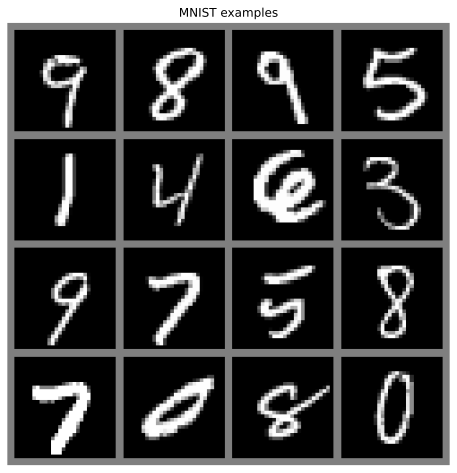

In [5]:
exmp_imgs = [train_set[i][0] for i in range(16)]
# Organize the images into a grid for nicer visualization
img_grid = torchvision.utils.make_grid(torch.stack(exmp_imgs, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("MNIST examples")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [6]:
x = next(iter(train_loader))[0]
x_ = x.view(x.shape[0], -1)
x.shape

torch.Size([32, 1, 28, 28])

# Model

In [7]:
class Encoder(torch.nn.Module):
    
    def __init__(self, input_size, latent_dim, hidden_dims):
        super(Encoder, self).__init__()
        
        layers = []
        layer_sizes = [input_size] + hidden_dims + [latent_dim]
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1],
                                 layer_sizes[layer_index]),
                        nn.ReLU()]
                
        self.layers_enc = nn.Sequential(*layers)        
    
    def forward(self, x):
        return self.layers_enc(x)

class Decoder(nn.Module):
    
    def __init__(self, input_size, latent_dim, hidden_dims):
        super(Decoder, self).__init__()
        layers = []
        layer_sizes = [latent_dim] + hidden_dims
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                        nn.ReLU()]
            
        layers += [nn.Linear(layer_sizes[-1], input_size),
                   nn.Identity()]
        
        self.layers_dec = nn.Sequential(*layers)
        
                
    def forward(self, x):
        return self.layers_dec(x)


class AutoEncoder(nn.Module):
    
    def __init__(self, latent_dim, input_size, hidden_dims):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(input_size, latent_dim, hidden_dims)
        self.decoder = Decoder(input_size, latent_dim, hidden_dims[::-1])
        

    def forward(self, x):
        return self.decoder(self.encoder(x))


class MNISTAutoEncoder(pl.LightningModule):
    
    def __init__(self, model_hparams, optimizer_name, optimizer_hparams):
        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        
        print(model_hparams)
        
        self.auto_encoder = AutoEncoder(**model_hparams)
        self.metric = torch.nn.MSELoss()
        
        # Example input for visualizing the graph in Tensorboard
        self.example_input_array = torch.zeros((1, 1, 28, 28), dtype=torch.float32)
        

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.auto_encoder.encoder(x)
    

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x = x.view(x.size(0), -1)
        x_hat = self.auto_encoder(x)
        loss = self.metric(x, x_hat)
        
        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        x = x.view(x.size(0), -1)
        x_hat = self.auto_encoder(x)
        loss = self.metric(x, x_hat)
        self.log(f"val_loss", loss, prog_bar=True)
        

    def test_step(self, batch, batch_idx):
        x, _ = batch
        x = x.view(x.size(0), -1)
        x_hat = self.auto_encoder(x)
        loss = self.metric(x, x_hat)
        self.log(f"test_loss", loss)
        
    
    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here for details: https://arxiv.org/pdf/1711.05101.pdf)
            optimizer = optim.AdamW(
                self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f"Unknown optimizer: \"{self.hparams.optimizer_name}\""


        return [optimizer]

# Training

In [8]:
EPOCHS=100

def train_model(seed=42, **kwargs):
    """
    Inputs:
        model_name - Name of the model you want to run. Is used to look up the class in "model_dict"
        save_name (optional) - If specified, this name will be used for creating the checkpoint and logging directory.
    """
    
    save_name = f"seed_{seed}"
    
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),                          # Where to save models
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",                     # We run on a GPU (if possible)
                         devices=1,                                                                          # How many GPUs/CPUs we want to use (1 is enough for the notebooks)
                         max_epochs=EPOCHS,                                                                     # How many epochs to train for if no patience is set
                         enable_progress_bar=True)                                                           # Set to False if you do not want a progress bar
    
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    pl.seed_everything(seed) # To be reproducable
    model = MNISTAutoEncoder(**kwargs)
    trainer.fit(model, train_loader, val_loader)

    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result[0]["test_loss"], "val": val_result[0]["test_loss"]}

    return model, result

In [9]:
model, results = train_model(seed=42,
                            model_hparams={"latent_dim":2,
                                           "input_size": 28*28,
                                           "hidden_dims": [500, 250, 100, 50],
                                           },
                            optimizer_name="Adam",
                            optimizer_hparams={"lr": 0.001},
                            )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'latent_dim': 2, 'input_size': 784, 'hidden_dims': [500, 250, 100, 50]}



  | Name         | Type        | Params | In sizes | Out sizes
--------------------------------------------------------------------
0 | auto_encoder | AutoEncoder | 1.1 M  | ?        | ?        
1 | metric       | MSELoss     | 0      | ?        | ?        
--------------------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.387     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\alexg\anaconda3\envs\rl_env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\alexg\anaconda3\envs\rl_env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

c:\Users\alexg\anaconda3\envs\rl_env\lib\site-packages\pytorch_lightning\trainer\call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\alexg\anaconda3\envs\rl_env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) 

Testing: 0it [00:00, ?it/s]

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

In [ ]:
results

{'test': 0.5883488059043884, 'val': 0.5923906564712524}

# Experiments